In [1]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("../augmented_dataset.csv")

# df = df.drop(columns=['BMI', 'BSA', 'IMT MAX', 'LVMi', 'EF', 'Record'])

# df['Gender'] = df['Gender'].str.upper().map({'M': 0, 'F': 1})
# df['Smoker'] = df['Smoker'].str.upper().map({'NO': 0, 'YES': 1})
df.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender,Vascular event
0,-2.221466,2.194940,1.746673,0.131399,0.485540,1.0,1.0,none
1,1.138972,0.176409,-0.359956,1.950732,-0.071100,0.0,0.0,none
2,0.718917,0.822339,1.465789,0.131399,1.042181,0.0,1.0,none
3,-0.821283,0.176409,0.904021,-1.343736,-1.184381,0.0,0.0,none
4,1.699045,-0.469520,0.342253,-0.852025,-0.627741,0.0,1.0,none


In [3]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [4]:
model = CTGANSynthesizer(metadata=metadata, epochs=3000)

/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [5]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
model = CTGANSynthesizer(metadata=metadata, epochs=3000, 
                         cuda=True, verbose=True)
model.fit(df)
# model.save("CTGAN_model.pkl")
synthetic_crfs = model.sample(421)
# synthetic_crfs.to_csv("synthetic_crfs.csv", index=False)

/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/Projects/MEng-Project/.venv/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.89) | Discrim. (0.19): 100%|██████████| 3000/3000 [02:19<00:00, 21.43it/s] 


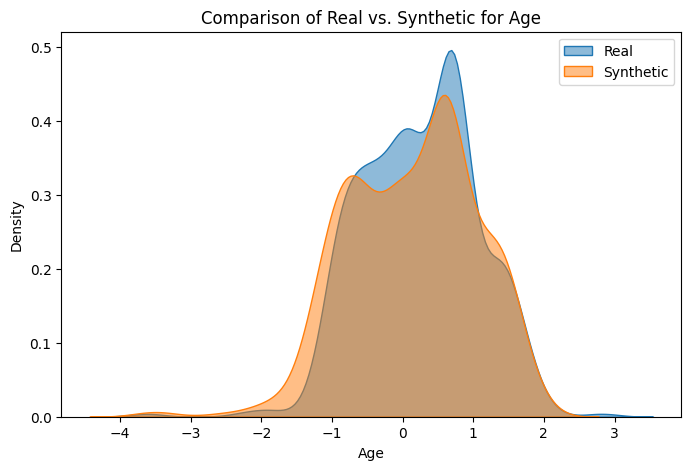

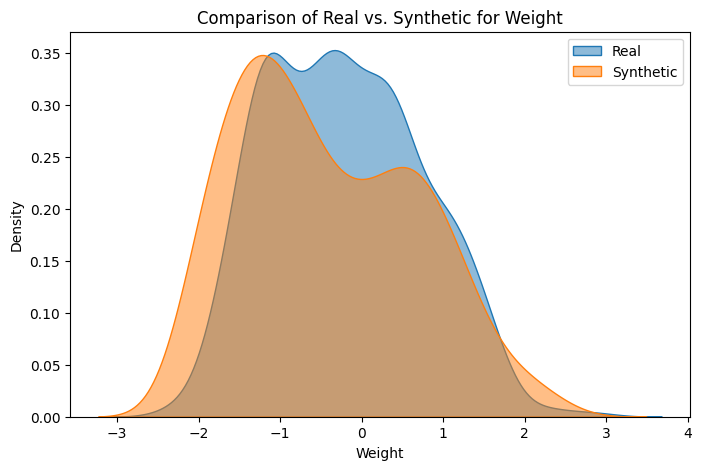

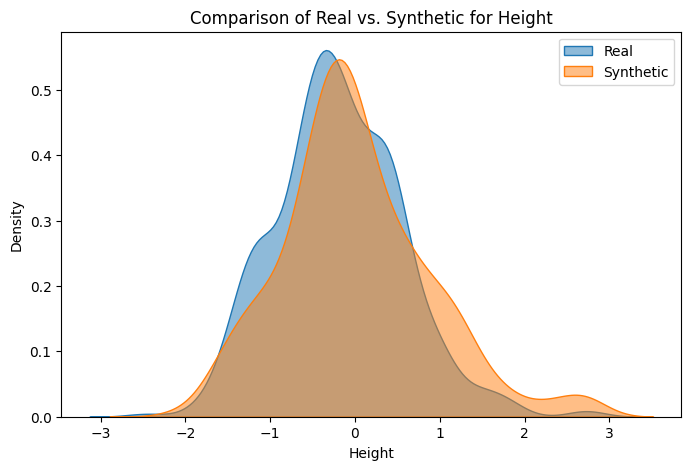

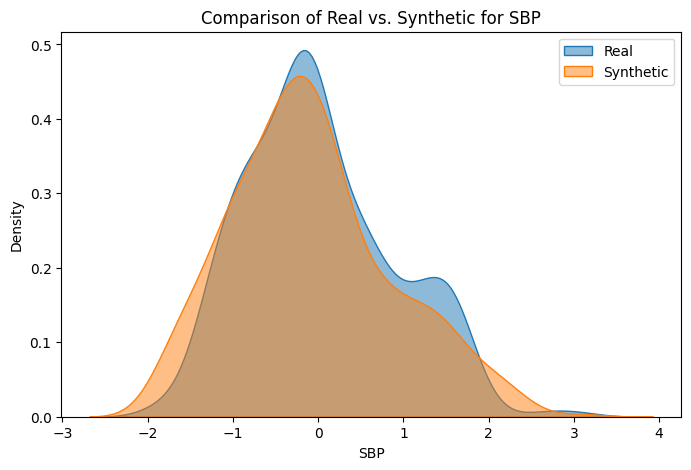

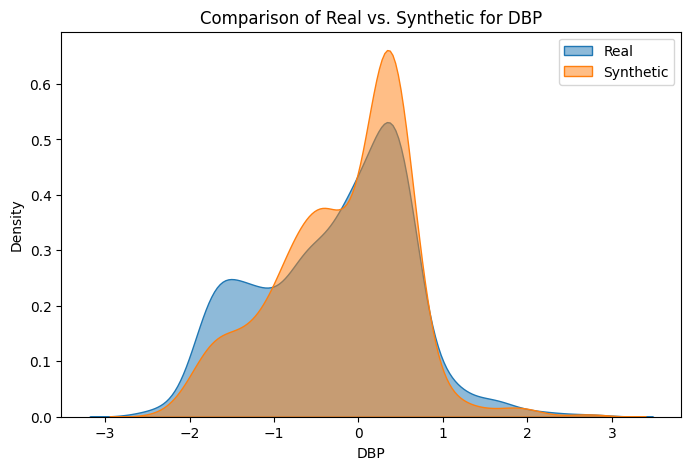

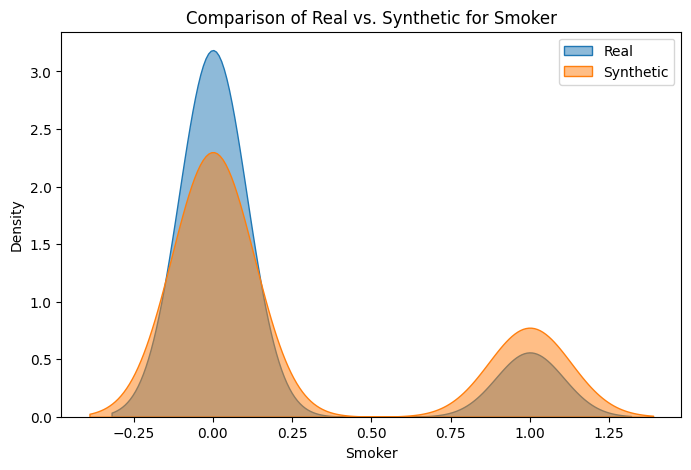

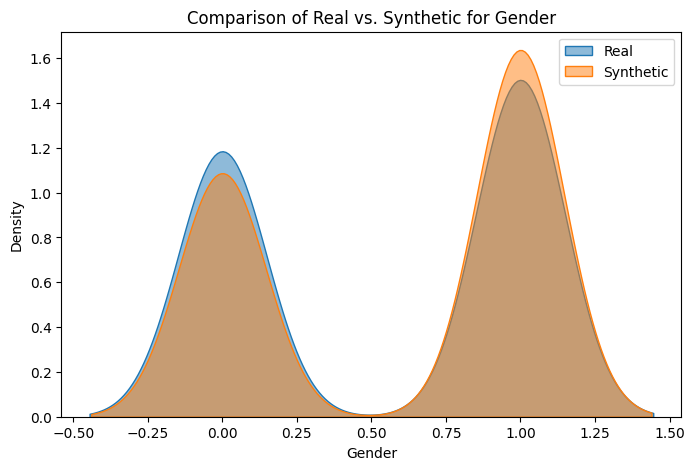

In [6]:
def distrib_comp():
    for column in df.columns:
        if column != "Vascular event":
            plt.figure(figsize=(8, 5))
            sns.kdeplot(df[column], label="Real", fill=True, alpha=0.5)
            sns.kdeplot(synthetic_crfs[column],
                        label="Synthetic", fill=True, alpha=0.5)
            plt.title(f"Comparison of Real vs. Synthetic for {column}")
            plt.legend()
            plt.show()

distrib_comp()

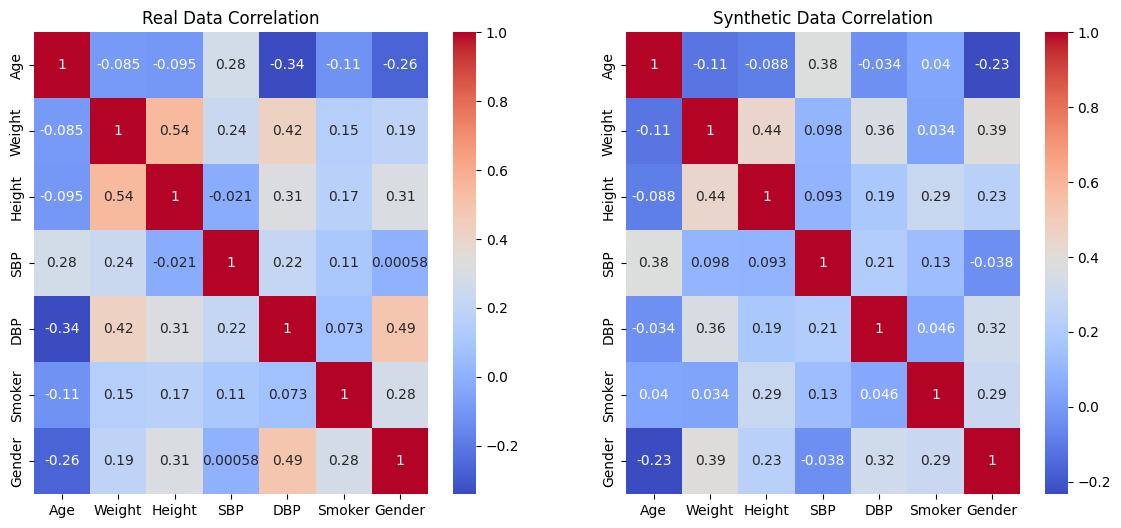

In [7]:
def correlation_heatmap():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(df.drop(columns=["Vascular event"]).corr(), ax=axes[0], cmap="coolwarm", annot=True)
    axes[0].set_title("Real Data Correlation")
    sns.heatmap(synthetic_crfs.drop(columns=["Vascular event"]).corr(), ax=axes[1], cmap="coolwarm", annot=True)
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()

correlation_heatmap()

In [8]:
def stat_distance_metric():
    for column in df.columns:
        if column != 'Vascular event':
            wd = wasserstein_distance(df[column], synthetic_crfs[column])
            ks_stat, ks_p = ks_2samp(df[column], synthetic_crfs[column])
            print(f"Feature: {column}")
            print(f"  Wasserstein Distance: {wd:.4f}")
            print(f"  KS Test p-value: {ks_p:.4f}")
            print("-" * 30)

stat_distance_metric()

Feature: Age
  Wasserstein Distance: 0.1324
  KS Test p-value: 0.0586
------------------------------
Feature: Weight
  Wasserstein Distance: 0.2406
  KS Test p-value: 0.0004
------------------------------
Feature: Height
  Wasserstein Distance: 0.2064
  KS Test p-value: 0.0075
------------------------------
Feature: SBP
  Wasserstein Distance: 0.1284
  KS Test p-value: 0.1314
------------------------------
Feature: DBP
  Wasserstein Distance: 0.1505
  KS Test p-value: 0.0075
------------------------------
Feature: Smoker
  Wasserstein Distance: 0.1025
  KS Test p-value: 0.0224
------------------------------
Feature: Gender
  Wasserstein Distance: 0.0417
  KS Test p-value: 0.8333
------------------------------


In [9]:
synthetic_crfs = model.sample(421)
target_column = "Vascular event"
X_real = df.drop(columns=[target_column])
X_real = X_real.fillna(X_real.mean())
y_real = df[target_column]
X_syn = synthetic_crfs.drop(columns=[target_column])
X_syn = X_syn.fillna(X_syn.mean())
y_syn = synthetic_crfs[target_column]

In [10]:
# Train on real, test on synthetic
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_syn = clf.predict(X_syn)
real_to_syn_acc = accuracy_score(y_syn, pred_syn)

In [11]:
# Train on synthetic, test on real
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, random_state=42)
clf_syn = RandomForestClassifier()
clf_syn.fit(X_train_syn, y_train_syn)
pred_real = clf_syn.predict(X_real)
syn_to_real_acc = accuracy_score(y_real, pred_real)

print(f"Train on Real → Test on Synthetic Accuracy: {real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.5368
Train on Synthetic → Test on Real Accuracy: 0.7085


In [12]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.60      0.55       118
                 none       0.41      0.65      0.50       108
               stroke       0.74      0.37      0.49        87
              syncope       0.79      0.49      0.61       108

             accuracy                           0.54       421
            macro avg       0.61      0.53      0.54       421
         weighted avg       0.60      0.54      0.54       421

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.64      0.64      0.64       108
                 none       0.52      0.38      0.44       104
               stroke       0.76      0.90      0.82       105
              syncope       0.83      0.91      0.87       105

             accuracy                           0.71       422

In [13]:
svm_real = SVC()
svm_real.fit(X_train, y_train)
svm_real_pred = svm_real.predict(X_syn)
svm_real_to_syn_acc = accuracy_score(y_syn, svm_real_pred)
svm_syn = SVC()
svm_syn.fit(X_train_syn, y_train_syn)
svm_syn_pred = svm_syn.predict(X_real)
svm_syn_to_real_acc = accuracy_score(y_real, svm_syn_pred)

print(f"Train on Real → Test on Synthetic Accuracy: {svm_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {svm_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.4941
Train on Synthetic → Test on Real Accuracy: 0.7085


In [14]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.60      0.55       118
                 none       0.41      0.65      0.50       108
               stroke       0.74      0.37      0.49        87
              syncope       0.79      0.49      0.61       108

             accuracy                           0.54       421
            macro avg       0.61      0.53      0.54       421
         weighted avg       0.60      0.54      0.54       421

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.64      0.64      0.64       108
                 none       0.52      0.38      0.44       104
               stroke       0.76      0.90      0.82       105
              syncope       0.83      0.91      0.87       105

             accuracy                           0.71       422

In [15]:
knn_real = KNeighborsClassifier()
knn_real.fit(X_train, y_train)
knn_real_pred = knn_real.predict(X_syn)
knn_real_to_syn_acc = accuracy_score(y_syn, knn_real_pred)

knn_syn = KNeighborsClassifier()
knn_syn.fit(X_train_syn, y_train_syn)
knn_syn_pred = knn_syn.predict(X_real)
knn_syn_to_real_acc = accuracy_score(y_real, knn_syn_pred)

print(f"Train on Real → Test on Synthetic (KNN) Accuracy: {knn_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real (KNN) Accuracy: {knn_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic (KNN) Accuracy: 0.5273
Train on Synthetic → Test on Real (KNN) Accuracy: 0.6777


In [16]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.51      0.60      0.55       118
                 none       0.41      0.65      0.50       108
               stroke       0.74      0.37      0.49        87
              syncope       0.79      0.49      0.61       108

             accuracy                           0.54       421
            macro avg       0.61      0.53      0.54       421
         weighted avg       0.60      0.54      0.54       421

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.64      0.64      0.64       108
                 none       0.52      0.38      0.44       104
               stroke       0.76      0.90      0.82       105
              syncope       0.83      0.91      0.87       105

             accuracy                           0.71       422

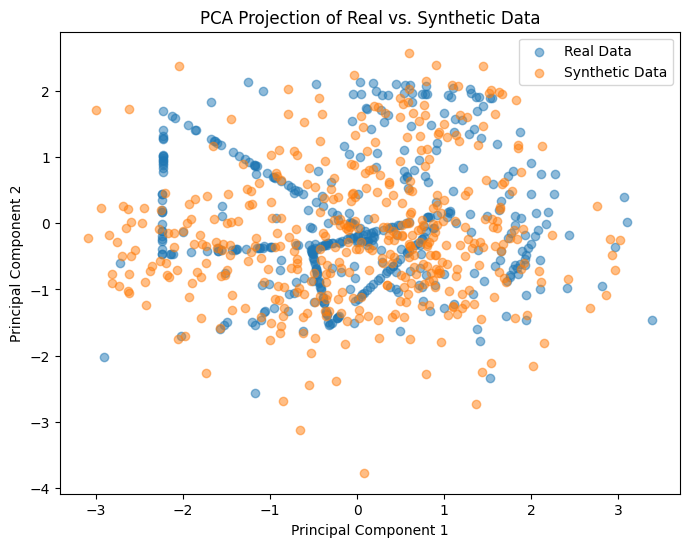

In [17]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X_real)
synthetic_pca = pca.transform(X_syn)
plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], label="Real Data", alpha=0.5)
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1],
            label="Synthetic Data", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA Projection of Real vs. Synthetic Data")
plt.show()

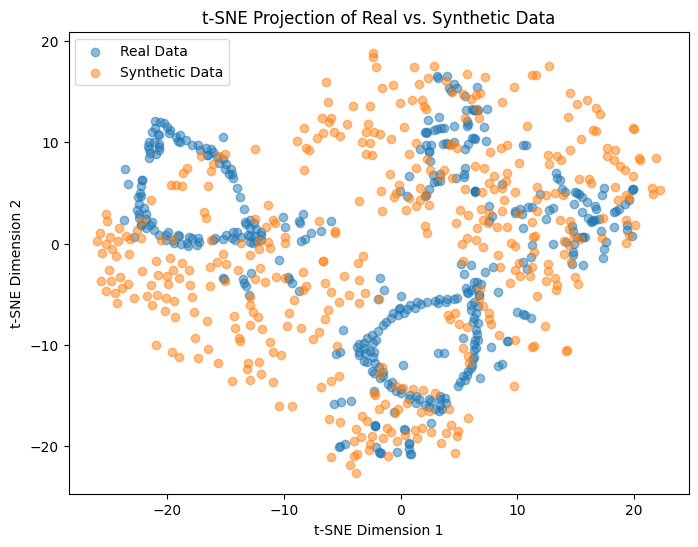

In [19]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_real_tsne = tsne.fit_transform(X_real)
X_smote_tsne = tsne.fit_transform(X_syn)
plt.figure(figsize=(8, 6))
plt.scatter(X_real_tsne[:,0], X_real_tsne[:,1], label="Real Data", alpha=0.5)
plt.scatter(X_smote_tsne[:,0], X_smote_tsne[:,1], label="Synthetic Data", alpha=0.5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.title("t-SNE Projection of Real vs. Synthetic Data")
plt.show()